# 1. Импорт библиотек

In [1]:
# import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 2 Загрузка даннных

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 3 Подготовка данных - Очистка

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#проверка на пустые значенич
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#удалим CustomerID
df = df.dropna(subset=['CustomerID'])

In [7]:
#проверим на дубликаты
df.duplicated().sum()

5225

In [8]:
#удалим дубликаты
df = df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
# отфлильтруем по положительной цене и количеству
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


# 3. Подготовка данных для Когортного аналилиза

# Для когортного анализа создадим несколько столбцов:
## 1. Расчетный период (Billing period) -  Строковое представление года и месяца отдельной транзакции/счета
## 2.Группа когорт (Cohort Group) - Строковое представление года и месяца первой покупки клиента. Эта метка является общей для всех счетов для конкретного клиента.
## 3. Когортный период/когортный индекс (Cohort Period/ Cohort Index) - Полное представление стадии жизни клиента. Число представляет количество месяцев с момента первой покупки.

In [13]:
def get_month(x) : return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

In [19]:
def get_month_int (dfame, column):
    year = dfame[column].dt.year
    month = dfame[column].dt.month
    day = dfame[column].dt.day
    return year, month, day

invoice_year, invoice_month,_ = get_month_int(df, 'InvoiceMonth')
cohort_year, cohort_month,_ = get_month_int(df, 'CohortMonth')

In [22]:
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

In [23]:
df['CohortIndex'] = year_diff *12 + month_diff +1

In [25]:
df['CohortIndex'].unique

<bound method Series.unique of 0         1
1         1
2         1
3         1
4         1
         ..
541904    5
541905    5
541906    5
541907    5
541908    5
Name: CohortIndex, Length: 392692, dtype: int64>

In [28]:
# Посчитаем активность клиентов по месяцам для каждой когорты
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

In [29]:
cohort_data

CohortMonth  CohortIndex
2010-12-01   1              885
             2              324
             3              286
             4              340
             5              321
                           ... 
2011-10-01   2               86
             3               41
2011-11-01   1              323
             2               36
2011-12-01   1               41
Name: CustomerID, Length: 91, dtype: int64

In [30]:
# Возвращаем количество уникальных элементов в объекте
cohort_data = cohort_data.reset_index()
cohort_data

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321
...,...,...,...
86,2011-10-01,2,86
87,2011-10-01,3,41
88,2011-11-01,1,323
89,2011-11-01,2,36


In [31]:
cohort_count = cohort_data.pivot(index='CohortMonth', columns = 'CohortIndex', values='CustomerID')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
cohort_size = cohort_count.iloc[:,0]
cohort_size

CohortMonth
2010-12-01    885.0
2011-01-01    417.0
2011-02-01    380.0
2011-03-01    452.0
2011-04-01    300.0
2011-05-01    284.0
2011-06-01    242.0
2011-07-01    188.0
2011-08-01    169.0
2011-09-01    299.0
2011-10-01    358.0
2011-11-01    323.0
2011-12-01     41.0
Name: 1, dtype: float64

In [37]:
retention = cohort_count.divide(cohort_size, axis=0) #axis=0 чтобы обеспечить деление по оси строки
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


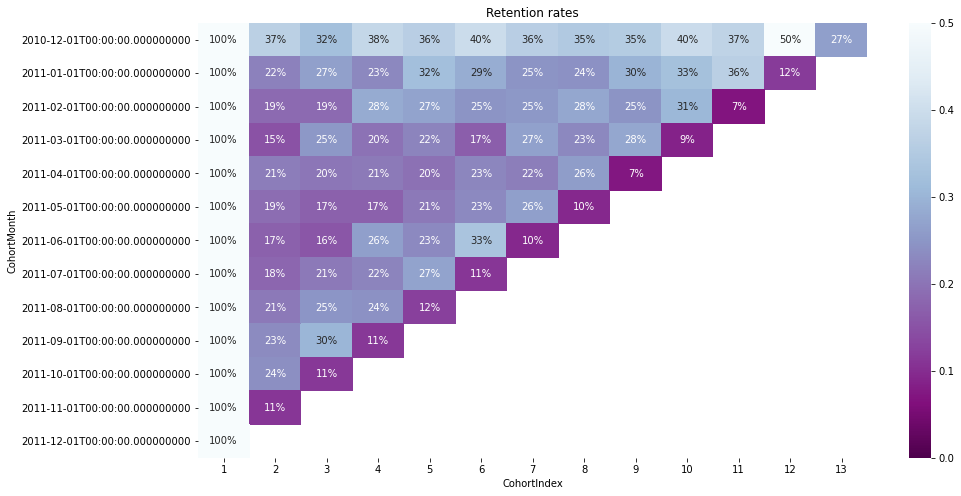

In [43]:
#Постороем тепловую карту
plt.figure(figsize=(15,8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap="BuPu_r")
plt.show()

In [44]:
#Посчитаем среднее количество для каждой когорты
grouping_avg = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_avg = grouping_avg['Quantity'] .mean()
cohort_data_avg = cohort_data_avg.reset_index()
average_quantity = cohort_data_avg.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,12.0,16.0,16.0,16.0,14.0,15.0,16.0,16.0,18.0,18.0,19.0,14.0,15.0
2011-01-01,17.0,13.0,13.0,15.0,13.0,15.0,15.0,15.0,12.0,11.0,10.0,10.0,NaN
2011-02-01,11.0,14.0,19.0,12.0,12.0,12.0,14.0,13.0,11.0,12.0,13.0,NaN,NaN
2011-03-01,10.0,12.0,13.0,10.0,14.0,13.0,13.0,14.0,11.0,10.0,NaN,NaN,NaN
2011-04-01,10.0,10.0,10.0,12.0,12.0,9.0,10.0,10.0,8.0,NaN,NaN,NaN,NaN
2011-05-01,11.0,10.0,14.0,13.0,11.0,9.0,11.0,114.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,11.0,15.0,11.0,14.0,11.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.0,14.0,7.0,8.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.0,6.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
average_quantity.index =average_quantity.index.date

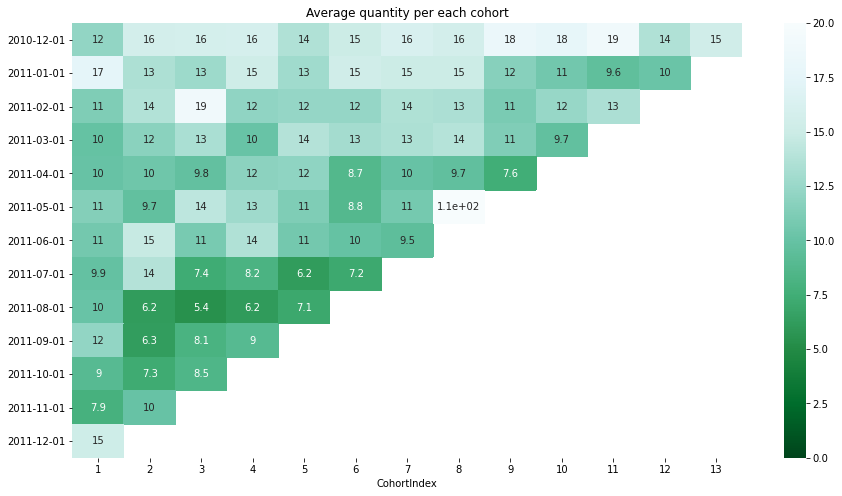

In [47]:
# Построим тепловую карту
plt.figure(figsize=(15,8))
plt.title('Average quantity per each cohort')
sns.heatmap(data=average_quantity, annot=True, vmin=0, vmax=20, cmap="BuGn_r")
plt.show()